In [8]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pydicom
import io
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Set seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("✅ Setup complete!")

✅ Setup complete!


In [9]:
# Load dataset
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
labels_df = pd.read_csv(os.path.join(dataset_path, "stage_2_train_labels.csv"))
class_df = pd.read_csv(os.path.join(dataset_path, "stage_2_detailed_class_info.csv"))

# Merge and clean data
merged = pd.merge(labels_df[['patientId','Target']], class_df[['patientId','class']], on='patientId')
merged = merged.drop_duplicates('patientId').reset_index(drop=True)

# Stratified split (80-20)
train_df, val_df = train_test_split(
    merged, 
    test_size=0.2, 
    stratify=merged['Target'], 
    random_state=SEED
)

print(f"Train samples: {len(train_df)}\nVal samples: {len(val_df)}")
print("\nClass distribution (Train):\n", train_df['Target'].value_counts())

Train samples: 21347
Val samples: 5337

Class distribution (Train):
 Target
0    16537
1     4810
Name: count, dtype: int64


In [10]:
# Simplified and fixed data pipeline
BATCH_SIZE = 32

# Training dataset
train_paths = [os.path.join(dataset_path, "stage_2_train_images", pid + ".dcm") for pid in train_df['patientId']]
train_labels = train_df['Target'].values.astype(np.int32)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(1000, reshuffle_each_iteration=True)

def process_train_element(path, label):
    # Read DICOM file
    img_bytes = tf.io.read_file(path)
    
    # Decode DICOM and normalize
    img = tf.numpy_function(
        lambda x: pydicom.dcmread(io.BytesIO(x)).pixel_array.astype(np.float32),
        [img_bytes],
        tf.float32
    )
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img) + 1e-7)
    img.set_shape((1024, 1024))  # Critical: Set initial shape
    
    # Convert to RGB and resize
    img = tf.expand_dims(img, axis=-1)  # (1024, 1024, 1)
    img = tf.image.grayscale_to_rgb(img)  # (1024, 1024, 3)
    img = tf.image.resize(img, [224, 224])  # (224, 224, 3)
    
    # Augmentation
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    return img, label

train_ds = train_ds.map(process_train_element, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).repeat()

# Validation dataset
val_paths = [os.path.join(dataset_path, "stage_2_train_images", pid + ".dcm") for pid in val_df['patientId']]
val_labels = val_df['Target'].values.astype(np.int32)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

def process_val_element(path, label):
    # Same processing without augmentation
    img_bytes = tf.io.read_file(path)
    
    img = tf.numpy_function(
        lambda x: pydicom.dcmread(io.BytesIO(x)).pixel_array.astype(np.float32),
        [img_bytes],
        tf.float32
    )
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img) + 1e-7)
    img.set_shape((1024, 1024))
    
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.image.resize(img, [224, 224])
    return img, label

val_ds = val_ds.map(process_val_element, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

print("✅ Datasets ready!")

✅ Datasets ready!


In [11]:
# ✅ Fix: Explicit shape definition at every step

# 1. Get file paths and labels (same as before)
train_paths = [os.path.join(dataset_path, "stage_2_train_images", pid + ".dcm") for pid in train_df['patientId']]
train_labels = train_df['Target'].values.astype(np.int32)

val_paths = [os.path.join(dataset_path, "stage_2_train_images", pid + ".dcm") for pid in val_df['patientId']]
val_labels = val_df['Target'].values.astype(np.int32)

# 2. Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

# 3. Preprocessing with enforced shapes
def process_path(path, label):
    # Read DICOM bytes
    img_bytes = tf.io.read_file(path)
    
    # Decode DICOM and enforce shape
    img = tf.numpy_function(
        lambda x: pydicom.dcmread(io.BytesIO(x)).pixel_array.astype(np.float32),
        [img_bytes],
        tf.float32
    )
    img.set_shape((1024, 1024))  # ⚠️ Critical fix: Set shape here
    
    # Normalize
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img) + 1e-7)
    
    # Add channel dim + convert to RGB
    img = tf.expand_dims(img, axis=-1)  # (1024, 1024, 1)
    img = tf.image.grayscale_to_rgb(img)  # (1024, 1024, 3)
    
    # Resize with known shape
    img = tf.image.resize(img, [224, 224])  # Now works
    
    # Augmentation
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    
    return img, label

# 4. Batch and prefetch
BATCH_SIZE = 32
train_ds = train_ds.map(process_path).shuffle(1000).batch(BATCH_SIZE).prefetch(2)
val_ds = val_ds.map(process_path).batch(BATCH_SIZE).prefetch(2)

In [12]:
# Calculate class weights
y_train = train_df['Target'].values
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weights)

Class weights: {0: 0.6454314567333858, 1: 2.219022869022869}


In [13]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.metrics import AUC

# Build model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:200]:
    layer.trainable = False

model = Sequential([
    base_model,
    SpatialDropout2D(0.7),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-4, clipnorm=1.0),
    loss=BinaryFocalCrossentropy(gamma=3.0),
    metrics=['accuracy', AUC(name='auc')]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 7, 7, 1920)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,444,993 (70.36 MB)

 Trainable params: 16,040,065 (61.19 MB)

 Non-trainable params: 2,404,928 (9.17 MB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

steps_per_epoch = len(train_df) // BATCH_SIZE

history = model.fit(
    train_ds,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 851s 739ms/step - accuracy: 0.5527 - auc: 0.5763 - loss: 6.2730 - val_accuracy: 0.7948 - val_auc: 0.8208 - val_loss: 4.7997 - learning_rate: 1.0000e-05
Epoch 2/30
  1/667 ━━━━━━━━━━━━━━━━━━━━ 49:08:24 266s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.7933

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


667/667 ━━━━━━━━━━━━━━━━━━━━ 336s 105ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.7933 - val_accuracy: 0.7952 - val_auc: 0.8208 - val_loss: 4.7975 - learning_rate: 1.0000e-05
Epoch 3/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 368s 530ms/step - accuracy: 0.6549 - auc: 0.6989 - loss: 4.5886 - val_accuracy: 0.7804 - val_auc: 0.8272 - val_loss: 3.4784 - learning_rate: 1.0000e-05
Epoch 4/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 69s 104ms/step - accuracy: 0.6667 - auc: 1.0000 - loss: 3.5284 - val_accuracy: 0.7819 - val_auc: 0.8273 - val_loss: 3.4769 - learning_rate: 1.0000e-05
Epoch 5/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 400s 578ms/step - accuracy: 0.6715 - auc: 0.7293 - loss: 3.2571 - val_accuracy: 0.7478 - val_auc: 0.8262 - val_loss: 2.4296 - learning_rate: 1.0000e-05
Epoch 6/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.6667 - auc: 0.5000 - loss: 2.5131 - val_accuracy: 0.7482 - val_auc: 0.8256 - val_loss: 2.4284 - learning_rate: 1.0000e-05
Epoch 7/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 353s 511ms/st

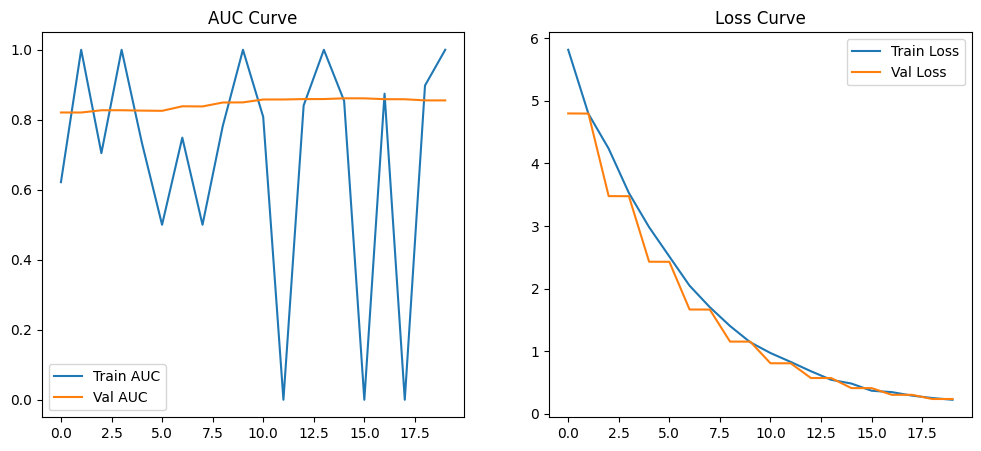

NameError: name 'classification_report' is not defined

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Generate predictions
y_true = []
y_pred = []
for batch in val_ds:
    images, labels = batch
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images, verbose=0).flatten())

y_pred_class = (np.array(y_pred) > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_true, y_pred_class, target_names=['Normal', 'Pneumonia']))
print("ROC-AUC:", roc_auc_score(y_true, y_pred))